# 01b Modelling - HPCGrad Variant

This notebook uses **HPCGrad** (Hierarchical PCGrad) instead of the standard PCGrad for gradient optimization.

**Key Changes:**
- Replaced `PCGrad` class with `HPCGrad` implementation from `scripts/hpcgrad.py`
- Uses hierarchical priority-based gradient projection
- Priority levels set to `[1, 1]` for equal priority between reconstruction and classification tasks

In [2]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.io
import requests
import os
from typing import Tuple, Dict, List
import random
import copy
import warnings
from pprint import pprint
import json

warnings.filterwarnings("ignore", category=UserWarning)

In [3]:


torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:


class HyperspectralDataset(Dataset):
    """Custom Dataset for Hyperspectral Data"""

    def __init__(self, data: np.ndarray, labels: np.ndarray, mask_ratio: float = 0.15):
        """
        Args:
            data: Hyperspectral data (N_samples, N_bands)
            labels: Class labels (N_samples,)
            mask_ratio: Ratio of spectral bands to mask for reconstruction task
        """
        self.data = torch.FloatTensor(data)
        self.labels = torch.LongTensor(labels)
        self.mask_ratio = mask_ratio
        self.n_bands = data.shape[1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        spectrum = self.data[idx]
        label = self.labels[idx]

        # Create masked spectrum for reconstruction task
        masked_spectrum = spectrum.clone()
        n_mask = int(self.n_bands * self.mask_ratio)

        # Random masking
        mask_indices = torch.randperm(self.n_bands)[:n_mask]
        mask = torch.zeros(self.n_bands, dtype=torch.bool)
        mask[mask_indices] = True

        masked_spectrum[mask] = 0.0  # or use learnable mask token

        return {
            'spectrum': spectrum,
            'masked_spectrum': masked_spectrum,
            'mask': mask,
            'label': label
        }

In [6]:
class HPCGrad():
    def __init__(self, optimizer, reduction='sum'):
        self._optim, self._reduction = optimizer, reduction
        self.eps = np.finfo(float).eps
        return

    @property
    def optimizer(self):
        return self._optim

    def zero_grad(self):
        '''
        clear the gradient of the parameters
        '''

        return self._optim.zero_grad(set_to_none=True)

    def step(self):
        '''
        update the parameters with the gradient
        '''

        return self._optim.step()

    def pc_backward(self, objectives, priorities):
        '''
        calculate the gradient of the parameters

        input:
        - objectives: a list of objectives
        - priorities: a list of integers of objective priorities
        '''

        grads, shapes, has_grads = self._pack_grad(objectives)
        pc_grad = self._project(grads, has_grads, priorities)
        pc_grad = self._unflatten_grad(pc_grad, shapes[0])
        self._set_grad(pc_grad)
        return
    
    def _project(self, grads, has_grads, priorities, shapes=None):
        prio_lb = np.min(np.array(priorities))
        prio_ub = np.max(np.array(priorities))
        grads_list = []
        has_grads_list = []
        # get all grads of this prio and perform standard PCGrad
        for prio in range(prio_lb, prio_ub+1):
            idx = [i for i, x in enumerate(priorities) if x == prio]
            grads_prio = []
            has_grads_prio = []
            for i in idx:
                grads_prio.append(grads[i])
                has_grads_prio.append(has_grads[i])
            #print('priorrity ', prio, ' has ', len(grads_prio), ' objectives')
            grad_prio = self._project_conflicting(grads_prio, has_grads_prio)
            grads_list.append(grad_prio)
            has_grad = torch.clip(torch.sum(torch.stack(has_grads_prio),dim=0), 0, 1)# sum all has_grads_prio tensors along the list dimension
            has_grads_list.append(has_grad) 

        # perform hierarchical PCgrad among the prio classes
        pc_grad = self._project_conflicting_hierarchical(grads_list, has_grads_list)
        return pc_grad
    
    def _project_conflicting(self, grads, has_grads, shapes=None):
        shared = torch.stack(has_grads).prod(0).bool()
        pc_grad, num_task = copy.deepcopy(grads), len(grads)
        for g_i in pc_grad:
            random.shuffle(grads)
            for g_j in grads:
                g_i_g_j = torch.dot(g_i, g_j)
                if g_i_g_j < 0 and g_j.norm() > self.eps:
                    g_i -= (g_i_g_j) * g_j / (g_j.norm()**2)

        merged_grad = torch.zeros_like(grads[0]).to(grads[0].device)
        if self._reduction:
            merged_grad[shared] = torch.stack([g[shared]
                                           for g in pc_grad]).mean(dim=0)
        elif self._reduction == 'sum':
            merged_grad[shared] = torch.stack([g[shared]
                                           for g in pc_grad]).sum(dim=0)
        else: exit('invalid reduction method')

        merged_grad[~shared] = torch.stack([g[~shared]
                                            for g in pc_grad]).sum(dim=0)
        return merged_grad
    
    def _project_conflicting_hierarchical(self, grads, has_grads, shapes=None):
        shared = torch.stack(has_grads).prod(0).bool()
        pc_grad, num_task = copy.deepcopy(grads), len(grads)
        # project each gradient onto the nullspace of the higher-priority tasks
        for j, g_j in enumerate(grads):
            if j+1<num_task:
                secondary_grads = pc_grad[j+1:]
                for i, g_i in enumerate(secondary_grads):
                    g_i_g_j = torch.dot(g_i, g_j)
                    if g_i_g_j < 0 and g_j.norm() > self.eps:
                        g_i -= (g_i_g_j) * g_j / (g_j.norm()**2)
            else:
                pass

        merged_grad = torch.zeros_like(grads[0]).to(grads[0].device)
        if self._reduction:
            merged_grad[shared] = torch.stack([g[shared]
                                           for g in pc_grad]).mean(dim=0)
        elif self._reduction == 'sum':
            merged_grad[shared] = torch.stack([g[shared]
                                           for g in pc_grad]).sum(dim=0)
        else: exit('invalid reduction method')

        merged_grad[~shared] = torch.stack([g[~shared]
                                            for g in pc_grad]).sum(dim=0)
        return merged_grad

    def _set_grad(self, grads):
        '''
        set the modified gradients to the network
        '''

        idx = 0
        for group in self._optim.param_groups:
            for p in group['params']:
                # if p.grad is None: continue
                p.grad = grads[idx]
                idx += 1
        return

    def _pack_grad(self, objectives):
        '''
        pack the gradient of the parameters of the network for each objective
        
        output:
        - grad: a list of the gradient of the parameters
        - shape: a list of the shape of the parameters
        - has_grad: a list of mask represent whether the parameter has gradient
        '''

        grads, shapes, has_grads = [], [], []
        for obj in objectives:
            self._optim.zero_grad(set_to_none=True)
            obj.backward(retain_graph=True)
            grad, shape, has_grad = self._retrieve_grad()
            grads.append(self._flatten_grad(grad, shape))
            has_grads.append(self._flatten_grad(has_grad, shape))
            shapes.append(shape)
        return grads, shapes, has_grads

    def _unflatten_grad(self, grads, shapes):
        unflatten_grad, idx = [], 0
        for shape in shapes:
            length = np.prod(shape)
            unflatten_grad.append(grads[idx:idx + length].view(shape).clone())
            idx += length
        return unflatten_grad

    def _flatten_grad(self, grads, shapes):
        flatten_grad = torch.cat([g.flatten() for g in grads])
        return flatten_grad

    def _retrieve_grad(self):
        '''
        get the gradient of the parameters of the network with specific 
        objective
        
        output:
        - grad: a list of the gradient of the parameters
        - shape: a list of the shape of the parameters
        - has_grad: a list of mask represent whether the parameter has gradient
        '''

        grad, shape, has_grad = [], [], []
        for group in self._optim.param_groups:
            for p in group['params']:
                # if p.grad is None: continue
                # tackle the multi-head scenario
                if p.grad is None:
                    shape.append(p.shape)
                    grad.append(torch.zeros_like(p).to(p.device))
                    has_grad.append(torch.zeros_like(p).to(p.device))
                    continue
                shape.append(p.grad.shape)
                grad.append(p.grad.clone())
                has_grad.append(torch.ones_like(p).to(p.device))
        return grad, shape, has_grad


In [7]:
class SharedEncoder(nn.Module):
    """Shared encoder for feature extraction (deterministic AE)"""

    def __init__(self, input_dim: int, latent_dim: int, hidden_dims: List[int] = [512, 256]):
        super(SharedEncoder, self).__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim

        self.shared_layers = nn.Sequential(*layers)

        # Latent bottleneck
        self.fc_latent = nn.Linear(prev_dim, latent_dim)

    def forward(self, x):
        h = self.shared_layers(x)  # high-level features
        z = self.fc_latent(h)      # latent representation
        return h, z

In [8]:


class Decoder(nn.Module):
    """Decoder for spectrum reconstruction"""

    def __init__(self, latent_dim: int, output_dim: int, hidden_dims: List[int] = [256, 512]):
        super(Decoder, self).__init__()

        layers = []
        prev_dim = latent_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.decoder = nn.Sequential(*layers)

    def forward(self, z):
        return self.decoder(z)

In [9]:
class ClassificationHead(nn.Module):
    """Classification head"""

    def __init__(self, feature_dim: int, num_classes: int):
        super(ClassificationHead, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

In [10]:
class MultitaskAE(nn.Module):
    """Vanilla Multitask Autoencoder"""

    def __init__(self, input_dim: int, latent_dim: int, num_classes: int, hidden_dims: List[int] = [512, 256]):
        super(MultitaskAE, self).__init__()

        self.encoder = SharedEncoder(input_dim, latent_dim, hidden_dims)
        self.decoder = Decoder(latent_dim, input_dim)
        self.classifier = ClassificationHead(hidden_dims[-1], num_classes)  # Use high-level features for classification

    def forward(self, x):
        h, z = self.encoder(x)  # h: high-level features, z: latent representation
        reconstructed = self.decoder(z)
        class_logits = self.classifier(h)
        return {
            'reconstructed': reconstructed,
            'class_logits': class_logits,
            'z': z,
            'features': h
        }

In [11]:


def ae_loss(recon_x, x, mask=None):
    """Autoencoder reconstruction loss with optional masking"""
    if mask is not None:
        # Only compute reconstruction loss for masked positions
        recon_loss = F.mse_loss(recon_x[mask], x[mask], reduction='mean')
    else:
        recon_loss = F.mse_loss(recon_x, x, reduction='mean')

    return recon_loss

In [12]:
class FocalLoss(nn.Module):
    """Focal Loss for addressing class imbalance"""
    
    def __init__(self, alpha=1, gamma=2, weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [18]:
# Check if data directory exists and list available CSV files
import os
import pandas as pd

data_dir = "../data/"
if os.path.exists(data_dir):
    csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
    print("Available CSV files:")
    for file in sorted(csv_files):
        print(f"  {file}")
else:
    print(f"Data directory '{data_dir}' not found!")
    print("Please ensure the data directory exists with CSV files.")

Available CSV files:
  df_field_b.csv
  df_field_g.csv
  df_screenh_b.csv
  df_screenh_g.csv


In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def load_dataset_from_csv():
    """
    Load dataset from CSV files in ../data/ directory (pre-merged train/test data)
    
    Returns:
        X_train, X_test, y_train, y_test, groups_train, groups_test, scaler
    """
    
    # List all available CSV files
    csv_files = ['df_field_b.csv', 'df_field_g.csv', 'df_screenh_b.csv', 'df_screenh_g.csv']
    
    X_list = []
    y_list = []
    groups_list = []
    
    print("Loading data from CSV files...")
    
    for file in csv_files:
        file_path = f"../data/{file}"
        if not os.path.exists(file_path):
            print(f"Warning: File {file_path} not found, skipping...")
            continue
            
        print(f"Loading {file}...")
        df = pd.read_csv(file_path, low_memory=False)
        
        # Get spectral columns (all numeric columns except 'y' and 'plant')
        spectral_cols = [col for col in df.columns if col not in ['y', 'plant']]
        
        # Extract features, labels, and groups
        X = df[spectral_cols].values
        y = df['y'].values
        groups = df['plant'].values
        
        # Convert groups to string to handle mixed types before counting unique values
        groups = np.array([str(g) for g in groups])
        
        print(f"  Shape: {X.shape}, Classes: {np.unique(y)}, Groups: {len(np.unique(groups))}")
        
        X_list.append(X)
        y_list.append(y)
        groups_list.append(groups)
    
    if not X_list:
        raise ValueError("No CSV files found or loaded successfully!")
    
    # Combine all data
    X_combined = np.vstack(X_list)
    y_combined = np.hstack(y_list)
    groups_combined = np.hstack(groups_list)
    
    print(f"\nCombined data shape: {X_combined.shape}")
    print(f"Combined classes: {np.unique(y_combined)}")
    print(f"Total groups: {len(np.unique(groups_combined))}")
    
    # Remove any NaN values
    valid_mask = ~(np.isnan(X_combined).any(axis=1) | np.isnan(y_combined))
    X_combined = X_combined[valid_mask]
    y_combined = y_combined[valid_mask]
    groups_combined = groups_combined[valid_mask]
    
    print(f"After removing NaN - Data shape: {X_combined.shape}")
    
    # Convert labels to start from 0 (if they don't already)
    unique_labels = np.unique(y_combined)
    print(f"Original label range: {unique_labels}")
    
    if unique_labels.min() != 0:
        print("Converting labels to start from 0...")
        label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(unique_labels))}
        y_combined = np.array([label_mapping[label] for label in y_combined])
        print(f"New label range: {np.unique(y_combined)}")
    
    # Split into train and test using GroupShuffleSplit
    from sklearn.model_selection import GroupShuffleSplit
    
    gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    train_idx, test_idx = next(gss.split(X_combined, y_combined, groups_combined))
    
    X_train, X_test = X_combined[train_idx], X_combined[test_idx]
    y_train, y_test = y_combined[train_idx], y_combined[test_idx]
    groups_train, groups_test = groups_combined[train_idx], groups_combined[test_idx]
    
    # Normalize features using StandardScaler
    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train.astype(np.float32))
    X_test_norm = scaler.transform(X_test.astype(np.float32))
    
    print(f"Spectral bands/features: {X_train_norm.shape[1]}")
    print(f"Training samples: {X_train_norm.shape[0]}")
    print(f"Test samples: {X_test_norm.shape[0]}")
    print(f"Training classes: {np.unique(y_train)}")
    print(f"Test classes: {np.unique(y_test)}")
    
    return X_train_norm, X_test_norm, y_train.astype(np.int32), y_test.astype(np.int32), groups_train, groups_test, scaler

# Legacy function for backward compatibility
def load_dataset(data_path=None, gt_path=None):
    """Legacy function - now loads from CSV files instead of MATLAB files"""
    print("Note: load_dataset now loads from CSV files in ../data/ directory")
    X_train, X_test, y_train, y_test, groups_train, groups_test, scaler = load_dataset_from_csv()

    # Combine train and test for backward compatibility
    X_combined = np.vstack([X_train, X_test])
    y_combined = np.hstack([y_train, y_test])
    groups_combined = np.hstack([groups_train, groups_test])

    return X_combined, y_combined, groups_combined, scaler

def split(X, y, groups, test_size=0.2, random_state=42):
    """Split dataset into training and validation sets using GroupShuffleSplit"""
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, val_idx = next(gss.split(X, y, groups))

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    groups_train, groups_val = groups[train_idx], groups[val_idx]

    print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")
    return X_train, X_val, y_train, y_val, groups_train, groups_val

In [16]:
def prepare_data(n_splits=5):
    """Load and prepare dataset for StratifiedGroupKFold cross-validation"""
    print("Loading dataset...")
    data, labels, groups, scaler = load_dataset()
    
    labels = np.array([int(str(label).replace('O', '0')) for label in labels])
    labels = labels.astype(np.int32)
    groups = np.array([str(group).replace('O', '0') for group in groups])
    groups = groups.astype(np.int32)

    print(f"Total samples: {data.shape[0]}")
    print(f"Using StratifiedGroupKFold with {n_splits} folds")

    return data, labels, groups, scaler

def split_data(X, y, groups, test_size=0.3, random_state=42):
    """Split dataset into training and validation sets using GroupShuffleSplit"""
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, val_idx = next(gss.split(X, y, groups))

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    groups_train, groups_val = groups[train_idx], groups[val_idx]

    print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")
    return X_train, X_val, y_train, y_val, groups_train, groups_val


def create_dataloaders(X_train, X_val, y_train, y_val, batch_size=64, mask_ratio=0.15):
    """Create datasets and dataloaders for a single fold"""
    train_dataset = HyperspectralDataset(X_train, y_train, mask_ratio=mask_ratio)
    val_dataset = HyperspectralDataset(X_val, y_val, mask_ratio=mask_ratio)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


def setup_model_and_optimizer(input_dim, num_classes, latent_dim=64, lr=1e-3):
    """Initialize model, optimizer, and scheduler"""
    model = MultitaskAE(input_dim, latent_dim, num_classes).to(device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    optimizer = HPCGrad(optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4))
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer.optimizer, mode='min', factor=0.5, patience=10
    )

    return model, optimizer, scheduler


def setup_loss_functions(y_train):
    """Initialize loss functions with class weights"""
    class_counts = np.bincount(y_train)
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum() * len(class_weights)
    class_weights_tensor = torch.FloatTensor(class_weights).to(device)
    
    focal_loss = FocalLoss(alpha=1, gamma=2, weight=class_weights_tensor, reduction='mean')
    print(f"Using Focal Loss with class weights: {class_weights}")
    
    return focal_loss


def train_epoch(model, train_loader, optimizer, focal_loss, alpha_recon=1.0, alpha_class=1.0):
    """Single training epoch"""
    model.train()
    train_loss_epoch = train_recon_loss_epoch = train_class_loss_epoch = 0
    train_correct = train_total = 0

    for batch in train_loader:
        spectrum = batch['spectrum'].to(device)
        masked_spectrum = batch['masked_spectrum'].to(device)
        mask = batch['mask'].to(device)
        labels_batch = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(masked_spectrum)

        recon_loss = ae_loss(outputs['reconstructed'], spectrum, mask)
        class_loss = focal_loss(outputs['class_logits'], labels_batch)
        total_loss = alpha_recon * recon_loss + alpha_class * class_loss

        optimizer.pc_backward([recon_loss, class_loss], [1, 0])
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss_epoch += total_loss.item()
        train_recon_loss_epoch += recon_loss.item()
        train_class_loss_epoch += class_loss.item()

        _, predicted = torch.max(outputs['class_logits'].data, 1)
        train_total += labels_batch.size(0)
        train_correct += (predicted == labels_batch).sum().item()

    return {
        'loss': train_loss_epoch / len(train_loader),
        'recon_loss': train_recon_loss_epoch / len(train_loader),
        'class_loss': train_class_loss_epoch / len(train_loader),
        'accuracy': 100 * train_correct / train_total
    }


def validate_epoch(model, val_loader, focal_loss, alpha_recon=1.0, alpha_class=1.0):
    """Single validation epoch"""
    model.eval()
    val_loss_epoch = val_recon_loss_epoch = val_class_loss_epoch = 0
    val_correct = val_total = 0
    val_predictions = val_targets = []

    with torch.no_grad():
        for batch in val_loader:
            spectrum = batch['spectrum'].to(device)
            masked_spectrum = batch['masked_spectrum'].to(device)
            mask = batch['mask'].to(device)
            labels_batch = batch['label'].to(device)

            outputs = model(masked_spectrum)
            recon_loss = ae_loss(outputs['reconstructed'], spectrum, mask)
            class_loss = focal_loss(outputs['class_logits'], labels_batch)
            total_loss = alpha_recon * recon_loss + alpha_class * class_loss

            val_loss_epoch += total_loss.item()
            val_recon_loss_epoch += recon_loss.item()
            val_class_loss_epoch += class_loss.item()

            _, predicted = torch.max(outputs['class_logits'].data, 1)
            val_total += labels_batch.size(0)
            val_correct += (predicted == labels_batch).sum().item()
            
            val_predictions.extend(predicted.cpu().numpy())
            val_targets.extend(labels_batch.cpu().numpy())

    return {
        'loss': val_loss_epoch / len(val_loader),
        'recon_loss': val_recon_loss_epoch / len(val_loader),
        'class_loss': val_class_loss_epoch / len(val_loader),
        'accuracy': 100 * val_correct / val_total,
        'f1_score': f1_score(val_targets, val_predictions, average='weighted')
    }


def evaluate_oof_set(model, oof_loader, oof_indices, X_data, y_data):
    """Evaluate on OOF (out-of-fold) set and collect predictions"""
    model.eval()
    oof_predictions = []
    oof_targets = []
    oof_features = []

    with torch.no_grad():
        for batch in oof_loader:
            masked_spectrum = batch['masked_spectrum'].to(device)
            labels_batch = batch['label'].to(device)

            outputs = model(masked_spectrum)
            _, predicted = torch.max(outputs['class_logits'].data, 1)
            
            oof_predictions.extend(predicted.cpu().numpy())
            oof_targets.extend(labels_batch.cpu().numpy())
            oof_features.extend(outputs['features'].cpu().numpy())

    oof_accuracy = 100 * np.mean(np.array(oof_predictions) == np.array(oof_targets))
    oof_f1 = f1_score(oof_targets, oof_predictions, average='weighted')

    return oof_predictions, oof_targets, oof_features, oof_accuracy, oof_f1


def plot_training_results(history, oof_targets, oof_predictions, output_dir='./HPCGrad'):
    """Plot training curves and confusion matrix"""
    plt.figure(figsize=(20, 5))

    # 1. Classification Loss
    plt.subplot(1, 4, 1)
    plt.plot(history['train_class_losses'], label='Train Class')
    plt.plot(history['val_class_losses'], label='Val Class')
    plt.title('Classification Loss (Focal Loss)')
    plt.xlabel('Epoch')
    plt.ylabel('Classification Loss')
    plt.legend()

    # 2. Reconstruction Loss
    plt.subplot(1, 4, 2)
    plt.plot(history['train_recon_losses'], label='Train Recon')
    plt.plot(history['val_recon_losses'], label='Val Recon')
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Reconstruction Loss')
    plt.legend()

    # 3. Train-Val Accuracy
    plt.subplot(1, 4, 3)
    plt.plot(history['train_accuracies'], label='Train Acc')
    plt.plot(history['val_accuracies'], label='Val Acc')
    plt.title('Train-Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # 4. Confusion Matrix
    plt.subplot(1, 4, 4)
    cm = confusion_matrix(oof_targets, oof_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f'{output_dir}/training_curves_multitask_ae.png')
    print(f"✅ Training plot saved to {output_dir}/training_curves_multitask_ae.png")


def train_multitask_model(epochs=100, batch_size=64, latent_dim=64, 
                         alpha_recon=1.0, alpha_class=1.0, patience=15, output_dir='./HPCGrad', n_splits=5):
    """Main modular training function with StratifiedGroupKFold cross-validation"""
    
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Prepare data
    X, y, groups, scaler = prepare_data(n_splits=n_splits)

    # 1.1 Split data into train and test
    X, X_test, y, y_test, groups, groups_test = split_data(X, y, groups, test_size=0.3)
    
    # 2. Setup StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # 3. Setup model parameters
    input_dim = X.shape[1]
    num_classes = len(np.unique(y))
    
    # Storage for test set predictions
    test_predictions_per_fold = []
    test_features_per_fold = []
    fold_histories = []
    fold_metrics = []
    metric = {}
    
    print(f"\nInput: {input_dim}, Classes: {num_classes}, Latent: {latent_dim}")
    print(f"Starting {n_splits}-fold cross-validation training...\n")
    print(f"Test set size: {X_test.shape[0]} samples\n")
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, y, groups)):
        print(f"\n{'='*60}")
        print(f"Fold {fold + 1}/{n_splits}")
        print(f"{'='*60}")
        
        # Split data for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        print(f"Train samples: {X_train.shape[0]}, Val samples: {X_val.shape[0]}")
        
        # Create dataloaders
        train_loader, val_loader = create_dataloaders(
            X_train, X_val, y_train, y_val, batch_size=batch_size
        )
        
        # Setup model and optimizer for this fold
        model, optimizer, scheduler = setup_model_and_optimizer(
            input_dim, num_classes, latent_dim
        )
        
        # Setup loss functions
        focal_loss = setup_loss_functions(y_train)
        
        # Training loop for this fold
        history = {
            'train_losses': [], 'val_losses': [],
            'train_accuracies': [], 'val_accuracies': [],
            'train_recon_losses': [], 'val_recon_losses': [],
            'train_class_losses': [], 'val_class_losses': []
        }
        
        best_val_loss = float('inf')
        best_epoch = 0
        best_metrics = {}
        patience_counter = 0
        
        for epoch in range(epochs):
            train_metrics = train_epoch(model, train_loader, optimizer, focal_loss, alpha_recon, alpha_class)
            val_metrics = validate_epoch(model, val_loader, focal_loss, alpha_recon, alpha_class)
            
            history['train_losses'].append(train_metrics['loss'])
            history['val_losses'].append(val_metrics['loss'])
            history['train_accuracies'].append(train_metrics['accuracy'])
            history['val_accuracies'].append(val_metrics['accuracy'])
            history['train_recon_losses'].append(train_metrics['recon_loss'])
            history['val_recon_losses'].append(val_metrics['recon_loss'])
            history['train_class_losses'].append(train_metrics['class_loss'])
            history['val_class_losses'].append(val_metrics['class_loss'])
            
            scheduler.step(val_metrics['loss'])
            
            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                best_epoch = epoch + 1
                best_metrics = {
                    "val": val_metrics,
                    "train": train_metrics
                }
                patience_counter = 0
                checkpoint_path = f'{output_dir}/best_multitask_ae_model_fold{fold+1}.pth'
                torch.save(model.state_dict(), checkpoint_path)
                print(f'Epoch [{epoch+1}/{epochs}] - NEW BEST: Loss (class): {val_metrics["class_loss"]:.4f}, Loss (recon): {val_metrics["recon_loss"]:.4f}, Acc: {val_metrics["accuracy"]:.2f}%')
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}\n")
                break
        
        
        # 4. Evaluate on test set
        checkpoint_path = f'{output_dir}/best_multitask_ae_model_fold{fold+1}.pth'
        model.load_state_dict(torch.load(checkpoint_path))
        
        test_dataset = HyperspectralDataset(X_test, y_test, mask_ratio=0.15)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        test_predictions = []
        test_targets = []
        test_features = []
        
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                masked_spectrum = batch['masked_spectrum'].to(device)
                labels_batch = batch['label'].to(device)
                
                outputs = model(masked_spectrum)
                _, predicted = torch.max(outputs['class_logits'].data, 1)
                
                test_predictions.extend(predicted.cpu().numpy())
                test_targets.extend(labels_batch.cpu().numpy())
                test_features.extend(outputs['features'].cpu().numpy())
        
        test_accuracy = 100 * np.mean(np.array(test_predictions) == np.array(test_targets))
        test_f1 = f1_score(test_targets, test_predictions, average='weighted')
        
        print(f'\nFold {fold + 1} Test Accuracy: {test_accuracy:.2f}%')
        print(f'Fold {fold + 1} Test F1 Score: {test_f1:.4f}')
        
        # Store test predictions and features for each fold
        test_predictions_per_fold.append(test_predictions)
        test_features_per_fold.append(test_features)
        
        fold_histories.append(history)
        fold_metrics.append({
            'fold': fold + 1,
            'accuracy': test_accuracy,
            'f1_score': test_f1
        })
        
        metric[f'fold_{fold+1}'] = best_metrics
        
    pprint(metric)

    with open(f'{output_dir}/multitask_ae_fold_metrics.json', 'w') as f:
        json.dump(metric, f, indent=4)

    # 5. Calculate overall test metrics (ensemble from all folds)
    test_predictions_ensemble_hard = np.round(np.mean(test_predictions_per_fold, axis=0)).astype(int)
    
    overall_test_accuracy = 100 * np.mean(test_predictions_ensemble_hard == test_targets)
    overall_test_f1 = f1_score(test_targets, test_predictions_ensemble_hard, average='weighted')
    
    print(f"\n{'='*60}")
    print("Overall Test Results (5-Fold Ensemble)")
    print(f"{'='*60}")
    print(f'Overall Test Accuracy: {overall_test_accuracy:.2f}%')
    print(f'Overall Test F1 Score: {overall_test_f1:.4f}')
    print('\nTest Classification Report:')
    print(classification_report(test_targets, test_predictions_ensemble_hard))

    # Save classification report to csv
    report = classification_report(test_targets, test_predictions_ensemble_hard, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(f'{output_dir}/multitask_ae_classification_report.csv', index=True)
    print(f"✅ Classification report saved to {output_dir}/multitask_ae_classification_report.csv")
    
    # Plot results from first fold as representative
    plot_training_results(fold_histories[0], test_targets, test_predictions_ensemble_hard, output_dir)
    
    return model, (test_features_per_fold, test_targets, test_predictions_ensemble_hard), scaler

Memory cleared. Starting fresh training with Focal Loss...

Loading dataset...
Note: load_dataset now loads from CSV files in ./data/ directory
Loading data from CSV files...
Loading df_field_b.csv...
  Shape: (3780, 2550), Classes: [0 1 2], Groups: 10
Loading df_field_g.csv...
  Shape: (3780, 2550), Classes: [0 1 2], Groups: 10
Loading df_screenh_b.csv...
  Shape: (4079, 2550), Classes: [0 1 2], Groups: 11
Loading df_screenh_g.csv...
  Shape: (4079, 2550), Classes: [0 1 2], Groups: 10

Combined data shape: (15718, 2550)
Combined classes: [0 1 2]
Total groups: 11
After removing NaN - Data shape: (15718, 2550)
Original label range: [0 1 2]
Spectral bands/features: 2550
Training samples: 9364
Test samples: 6354
Training classes: [0 1 2]
Test classes: [0 1 2]
Total samples: 15718
Using StratifiedGroupKFold with 5 folds
Training samples: 10996, Validation samples: 4722

Input: 2550, Classes: 3, Latent: 64
Starting 5-fold cross-validation training...

Test set size: 4722 samples


Fold 1/5


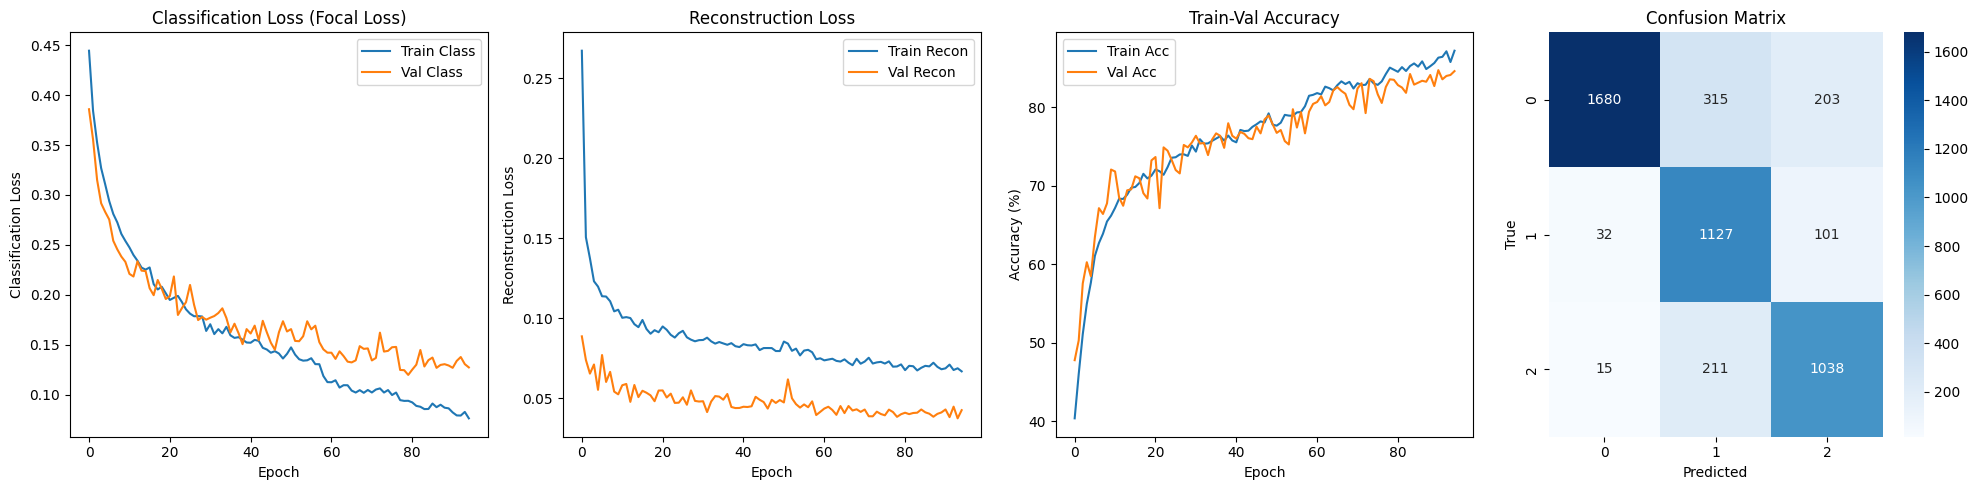

✅ Training plot saved to ./HPCGrad/training_curves_multitask_ae.png

Training completed successfully!
Best models saved with OOF validation
Collected OOF features from 5 folds
OOF predictions shape: (4722,)
Using Focal Loss for classification with StratifiedGroupKFold cross-validation


<Figure size 640x480 with 0 Axes>

In [15]:
# Clear any existing model and restart training cleanly
import gc
import torch

# Clear GPU memory if available
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Force garbage collection
gc.collect()

print("Memory cleared. Starting fresh training with Focal Loss...\n")

# Train the model with configurable parameters
model, test_results, scaler = train_multitask_model(
    epochs=500,
    batch_size=64,
    latent_dim=64,
    alpha_recon=1.0,
    alpha_class=1.0,
    patience=15,
    output_dir='./HPCGrad',
    n_splits=5
)

print("\nTraining completed successfully!")
print(f"Best models saved with OOF validation")

# Feature analysis
features_list, targets, predictions = test_results
print(f"Collected OOF features from {len(features_list)} folds")
print(f"OOF predictions shape: {np.array(predictions).shape}")
print("Using Focal Loss for classification with StratifiedGroupKFold cross-validation")


Visualizing reconstruction results on first fold validation set...

Loading dataset...
Note: load_dataset now loads from CSV files in ./data/ directory
Loading data from CSV files...
Loading df_field_b.csv...
  Shape: (3780, 2550), Classes: [0 1 2], Groups: 10
Loading df_field_g.csv...
  Shape: (3780, 2550), Classes: [0 1 2], Groups: 10
Loading df_screenh_b.csv...
  Shape: (4079, 2550), Classes: [0 1 2], Groups: 11
Loading df_screenh_g.csv...
  Shape: (4079, 2550), Classes: [0 1 2], Groups: 10

Combined data shape: (15718, 2550)
Combined classes: [0 1 2]
Total groups: 11
After removing NaN - Data shape: (15718, 2550)
Original label range: [0 1 2]
Spectral bands/features: 2550
Training samples: 9364
Test samples: 6354
Training classes: [0 1 2]
Test classes: [0 1 2]
Total samples: 15718
Using StratifiedGroupKFold with 5 folds


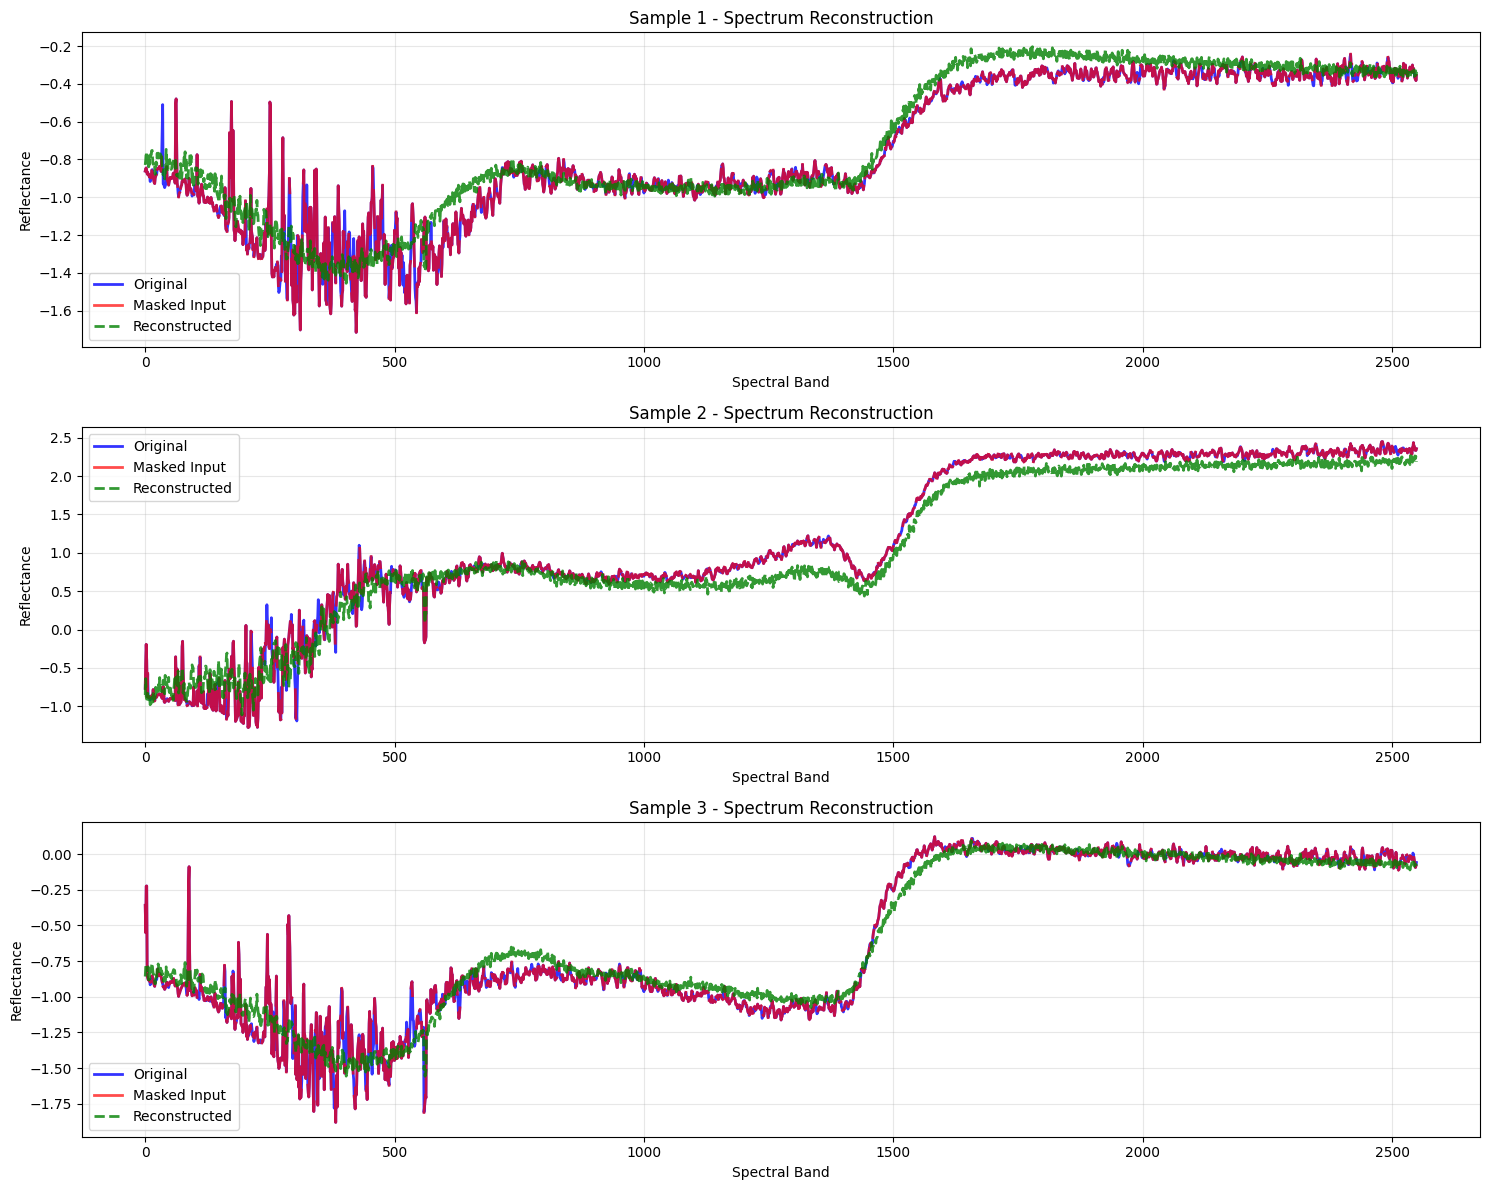

✅ Reconstruction visualization complete!


In [16]:
# Visualize reconstruction results on first fold
print("\nVisualizing reconstruction results on first fold validation set...\n")

# Prepare data and create first fold
X, y, groups, _ = prepare_data(n_splits=5)
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# Get first fold
for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, y, groups)):
    if fold == 0:
        X_val = X[val_idx]
        y_val = y[val_idx]
        break

# Create validation dataset and loader
val_dataset = HyperspectralDataset(X_val, y_val, mask_ratio=0.15)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model.eval()
with torch.no_grad():
    batch = next(iter(val_loader))
    spectrum = batch['spectrum'][:3].to(device)
    masked_spectrum = batch['masked_spectrum'][:3].to(device)
    mask = batch['mask'][:3].to(device)

    outputs = model(masked_spectrum)
    reconstructed = outputs['reconstructed']

    plt.figure(figsize=(15, 12))

    for i in range(3):
        plt.subplot(3, 1, i+1)

        # Plot original
        plt.plot(spectrum[i].cpu().numpy(), 'b-', label='Original', alpha=0.8, linewidth=2)

        # Plot masked input
        masked_plot = spectrum[i].cpu().numpy().copy()
        masked_plot[mask[i].cpu().numpy()] = np.nan
        plt.plot(masked_plot, 'r-', label='Masked Input', linewidth=2, alpha=0.7)

        # Plot reconstructed
        plt.plot(reconstructed[i].cpu().numpy(), 'g--', label='Reconstructed', alpha=0.8, linewidth=2)

        plt.title(f'Sample {i+1} - Spectrum Reconstruction')
        plt.xlabel('Spectral Band')
        plt.ylabel('Reflectance')
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("✅ Reconstruction visualization complete!")

Model Architecture Summary:
Model: MultitaskAE
Total parameters: 2,946,873
Trainable parameters: 2,946,873
✅ Graph saved to ./HPCGrad/MultitaskAE.gv


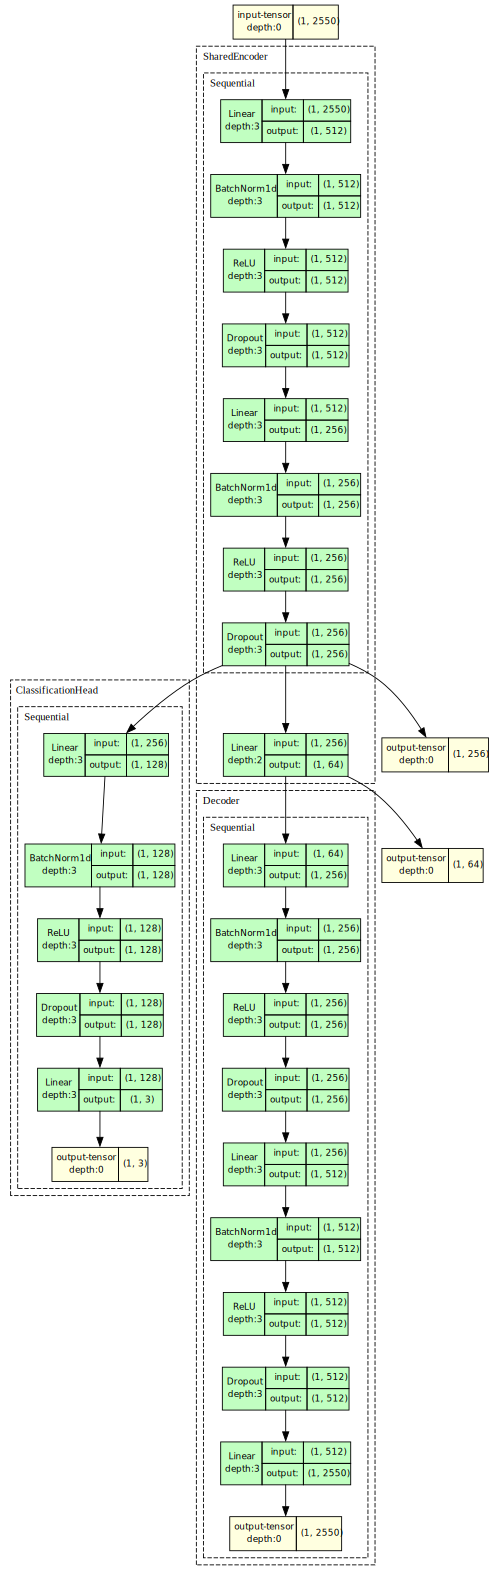

In [17]:
print("Model Architecture Summary:")
print(f"Model: {model.__class__.__name__}")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

from torchview import draw_graph

# 1. Define and eval model
model_viz = MultitaskAE(input_dim=2550, latent_dim=64, num_classes=3)
model_viz.eval()

# 2. Draw graph
graph = draw_graph(
    model_viz,
    input_size=(1, 2550),
    expand_nested=True,
    graph_name="MultitaskAE",
    roll=False,
)

# 3. Save the .gv file
os.makedirs('./HPCGrad', exist_ok=True)
gv_path = graph.visual_graph.save(filename="./HPCGrad/MultitaskAE.gv")
print(f"✅ Graph saved to ./HPCGrad/MultitaskAE.gv")

graph.visual_graph

In [18]:
from graphviz import Source

# Load the .gv file
src = Source.from_file('./HPCGrad/MultitaskAE.gv')

# Render it as PNG (creates graph.png)
src.render(filename='./HPCGrad/MultitaskAE', format='png', cleanup=True)

'HPCGrad/MultitaskAE.png'

In [20]:
# ========== EVALUATION ON TEST SET ==========

print("\n" + "="*60)
print("EVALUATION: Loading data and predicting with all 5 folds")
print("="*60)

# Load and prepare data using the same split method as training
X, y, groups, scaler = prepare_data(n_splits=5)
X, X_test, y, y_test, groups, groups_test = split_data(X, y, groups, test_size=0.3, random_state=42)

# Load all 5 trained models and make predictions
test_dataset = HyperspectralDataset(X_test, y_test, mask_ratio=0.15)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

all_predictions = []
all_features = []

for fold in range(1, 6):
    checkpoint_path = f'./HPCGrad/best_multitask_ae_model_fold{fold}.pth'
    
    if not os.path.exists(checkpoint_path):
        print(f"Warning: Checkpoint {checkpoint_path} not found, skipping fold {fold}")
        continue
    
    # Load model
    model_eval = MultitaskAE(input_dim=X_test.shape[1], latent_dim=64, num_classes=len(np.unique(y_test))).to(device)
    model_eval.load_state_dict(torch.load(checkpoint_path))
    model_eval.eval()
    
    fold_predictions = []
    fold_features = []
    
    with torch.no_grad():
        for batch in test_loader:
            masked_spectrum = batch['masked_spectrum'].to(device)
            outputs = model_eval(masked_spectrum)
            _, predicted = torch.max(outputs['class_logits'].data, 1)
            
            fold_predictions.extend(predicted.cpu().numpy())
            fold_features.extend(outputs['features'].cpu().numpy())
    
    all_predictions.append(fold_predictions)
    all_features.append(fold_features)
    print(f"Fold {fold} predictions collected")

# Ensemble predictions (hard voting - average and round)
ensemble_predictions = np.round(np.mean(all_predictions, axis=0)).astype(int)
y_true = y_test.astype(int)
y_pred = ensemble_predictions

# Calculate metrics
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

AA = per_class_acc.mean()
OA = (cm.diagonal().sum()) / cm.sum()

print("\n" + "="*60)
print("TEST SET RESULTS (5-Fold Ensemble)")
print("="*60)
print("OA:", OA)
print("AA:", AA)

print("\nClassification report:")
print(classification_report(y_true, y_pred))


EVALUATION: Loading data and predicting with all 5 folds
Loading dataset...
Note: load_dataset now loads from CSV files in ../data/ directory
Loading data from CSV files...
Loading df_field_b.csv...
  Shape: (3780, 2550), Classes: [0 1 2], Groups: 10
Loading df_field_g.csv...
  Shape: (3780, 2550), Classes: [0 1 2], Groups: 10
Loading df_field_g.csv...
  Shape: (3780, 2550), Classes: [0 1 2], Groups: 10
Loading df_screenh_b.csv...
  Shape: (3780, 2550), Classes: [0 1 2], Groups: 10
Loading df_screenh_b.csv...
  Shape: (4079, 2550), Classes: [0 1 2], Groups: 11
Loading df_screenh_g.csv...
  Shape: (4079, 2550), Classes: [0 1 2], Groups: 11
Loading df_screenh_g.csv...
  Shape: (4079, 2550), Classes: [0 1 2], Groups: 10

Combined data shape: (15718, 2550)
Combined classes: [0 1 2]
Total groups: 11
After removing NaN - Data shape: (15718, 2550)
Original label range: [0 1 2]
  Shape: (4079, 2550), Classes: [0 1 2], Groups: 10

Combined data shape: (15718, 2550)
Combined classes: [0 1 2]
To